In [1]:
from Bio import SeqIO
from Bio.KEGG import REST
from bioservices.kegg import KEGG
from collections import deque
import pandas as pd
import networkx as nx
import networkit as nt
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image
import time
import io
import os
from itertools import chain

%matplotlib inline

In [2]:
# helper functions

def get_rel_pathway(ids):
    """ retrieve related pathways from another pathway """
    dict_data = k.parse(k.get(ids))
    rel_pathway = []
    if 'REL_PATHWAY' in dict_data.keys():
        lst = dict_data['REL_PATHWAY'].split('             ')
        for l in lst:
            ids, desc = l.split('  ')
            rel_pathway.append([ids, desc])
    else:
        rel_pathway.append([ids, 'null'])
    return rel_pathway

def plot_network(graph):
    plt.figure(figsize=(20,20))
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph, pos, node_color='r')
    nx.draw_networkx_labels(graph, pos, font_size = 10)
    nx.draw_networkx_edges(graph, pos, edge_color='b')
    plt.show()

In [2]:
df_pathway = pd.read_csv('hsa05200_rel_pathways.csv')
df_gene = pd.read_csv('hsa05200_genes.csv')
df_compound = pd.read_csv('hsa05200_compounds.csv')
df_drug = pd.read_csv('hsa05200_drugs.csv')

In [3]:
k = KEGG()
k.organism = 'hsa'

In [4]:
df_pathway.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   rel_pathwayIds  21 non-null     object
dtypes: object(1)
memory usage: 296.0+ bytes


In [7]:
for i in range(len(df_pathway)):
    print (df_pathway.loc[i, 'rel_pathwayIds'])

hsa03320
hsa04010
hsa04020
hsa04024
hsa04060
hsa04066
hsa04110
hsa04115
hsa04150
hsa04151
hsa04210
hsa04310
hsa04330
hsa04340
hsa04350
hsa04370
hsa04510
hsa04512
hsa04520
hsa04630
hsa04915


In [8]:
dict_data = k.parse(k.get(df_pathway.loc[0, 'rel_pathwayIds']))
for key in dict_data.keys():
    print (key)

ENTRY
NAME
DESCRIPTION
CLASS
PATHWAY_MAP
DRUG
ORGANISM
GENE
COMPOUND
REFERENCE
REL_PATHWAY
KO_PATHWAY


In [11]:
dict_data

{'ENTRY': 'hsa03320                    Pathway',
 'NAME': ['PPAR signaling pathway - Homo sapiens (human)'],
 'DESCRIPTION': 'Peroxisome proliferator-activated receptors (PPARs) are nuclear hormone receptors that are activated by fatty acids and their derivatives. PPAR has three subtypes (PPARalpha, beta/delta, and gamma) showing different expression patterns in vertebrates. Each of them is encoded in a separate gene and binds fatty acids and eicosanoids. PPARalpha plays a role in the clearance of circulating or cellular lipids via the regulation of gene expression involved in lipid metabolism in liver and skeletal muscle. PPARbeta/delta is involved in lipid oxidation and cell proliferation. PPARgamma promotes adipocyte differentiation to enhance blood glucose uptake.',
 'CLASS': 'Organismal Systems; Endocrine system',
 'PATHWAY_MAP': {'hsa03320': 'PPAR signaling pathway'},
 'DRUG': {'D00279': 'Clofibrate (JP18/USP/INN)',
  'D00334': 'Gemfibrozil (JAN/USP/INN)',
  'D00395': 'Troglitazo

In [28]:
for i in range(len(df_pathway)):
    ids = df_pathway.loc[i, 'rel_pathwayIds']
    dict_data = k.parse(k.get(ids))
    if 'REL_PATHWAY' in dict_data.keys():
        print (ids, 'has related pathway')
    else:
        print (ids, 'DOES NOT have related pathway')

hsa03320 has related pathway
hsa04010 has related pathway
hsa04020 has related pathway
hsa04024 has related pathway
hsa04060 DOES NOT have related pathway
hsa04066 has related pathway
hsa04110 has related pathway
hsa04115 has related pathway
hsa04150 has related pathway
hsa04151 has related pathway
hsa04210 has related pathway
hsa04310 has related pathway
hsa04330 has related pathway
hsa04340 has related pathway
hsa04350 has related pathway
hsa04370 has related pathway
hsa04510 has related pathway
hsa04512 has related pathway
hsa04520 has related pathway
hsa04630 has related pathway
hsa04915 has related pathway


In [29]:
dict_data = k.parse(k.get('hsa04060')) # Treated separately
dict_data

{'ENTRY': 'hsa04060                    Pathway',
 'NAME': ['Cytokine-cytokine receptor interaction - Homo sapiens (human)'],
 'DESCRIPTION': 'Cytokines are soluble extracellular proteins or glycoproteins that are crucial intercellular regulators and mobilizers of cells engaged in innate as well as adaptive inflammatory host defenses, cell growth, differentiation, cell death, angiogenesis, and development and repair processes aimed at the restoration of homeostasis. Cytokines are released by various cells in the body, usually in response to an activating stimulus, and they induce responses through binding to specific receptors on the cell surface of target cells. Cytokines can be grouped by structure into different families and their receptors can likewise be grouped.',
 'CLASS': 'Environmental Information Processing; Signaling molecules and interaction',
 'PATHWAY_MAP': {'hsa04060': 'Cytokine-cytokine receptor interaction'},
 'NETWORK': {'ELEMENT': {'N01166': 'CCL3/5/7/8/13/14/15/16/23

In [27]:
%%time
pathway_to_pathway = []
for i in range(len(df_pathway)):
    ids = df_pathway.loc[i, 'rel_pathwayIds']
    all_pathways = get_rel_pathway(ids)
    for rel_path_ids, desc in all_pathways:
        pathway_to_pathway.append([ids, rel_path_ids])

CPU times: user 55.9 ms, sys: 7.05 ms, total: 62.9 ms
Wall time: 4.42 s


In [30]:
# Sample
pathway_to_pathway[0]

['hsa03320', 'hsa00071']

In [31]:
G = nx.Graph() # non-directed graph

In [34]:
%%time
for pairs in tqdm(pathway_to_pathway):
    source = pairs[0]
    target = pairs[1]
    G.add_node(source, name=k.parse(k.get(source))['NAME'])
    G.add_node(target, name=k.parse(k.get(target))['NAME'])
    G.add_edge(source, target)

100%|██████████| 119/119 [00:52<00:00,  2.25it/s]

CPU times: user 774 ms, sys: 112 ms, total: 886 ms
Wall time: 52.8 s


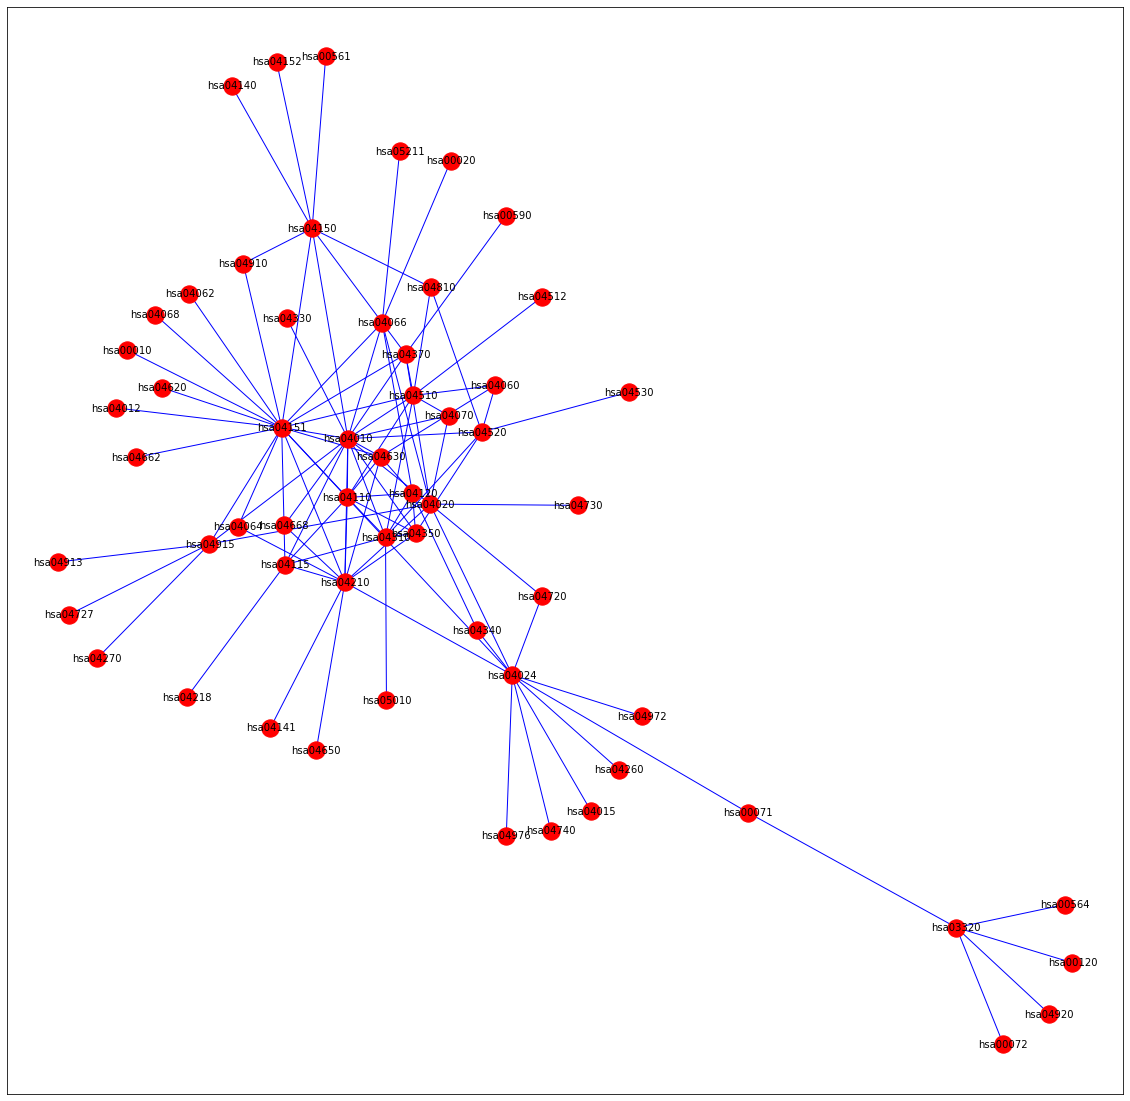

In [39]:
plot_network(G)

In [37]:
nx.write_gpickle(G, 'hsa05200_related_pathway_network.gpickle')

In [4]:
G = nx.read_gpickle('hsa05200_related_pathway_network.gpickle')

# Network Characteristics

In [5]:
# Check the neighbours of pathway hsa04060 which has no related pathways
hsa04060_neighbours = [n for n in G.neighbors('hsa04060') if n!='hsa04060']
print (hsa04060_neighbours)

['hsa04510', 'hsa04520', 'hsa04630']


In [6]:
# Centrality
centrality = nx.eigenvector_centrality(G)
node_centrality_score = sorted((v, f"{c:0.4f}") for v, c in centrality.items())
print (len(node_centrality_score))
node_centrality_score

59


[('hsa00010', '0.0482'),
 ('hsa00020', '0.0254'),
 ('hsa00071', '0.0178'),
 ('hsa00072', '0.0003'),
 ('hsa00120', '0.0003'),
 ('hsa00561', '0.0197'),
 ('hsa00564', '0.0003'),
 ('hsa00590', '0.0240'),
 ('hsa03320', '0.0025'),
 ('hsa04010', '0.4211'),
 ('hsa04012', '0.0482'),
 ('hsa04015', '0.0175'),
 ('hsa04020', '0.1994'),
 ('hsa04024', '0.1357'),
 ('hsa04060', '0.0835'),
 ('hsa04062', '0.0482'),
 ('hsa04064', '0.0862'),
 ('hsa04066', '0.1972'),
 ('hsa04068', '0.0482'),
 ('hsa04070', '0.1094'),
 ('hsa04110', '0.2948'),
 ('hsa04115', '0.2092'),
 ('hsa04120', '0.1471'),
 ('hsa04140', '0.0197'),
 ('hsa04141', '0.0380'),
 ('hsa04150', '0.1526'),
 ('hsa04151', '0.3744'),
 ('hsa04152', '0.0197'),
 ('hsa04210', '0.2949'),
 ('hsa04218', '0.0269'),
 ('hsa04260', '0.0175'),
 ('hsa04270', '0.0174'),
 ('hsa04310', '0.2124'),
 ('hsa04330', '0.0542'),
 ('hsa04340', '0.0364'),
 ('hsa04350', '0.1929'),
 ('hsa04370', '0.1861'),
 ('hsa04510', '0.2288'),
 ('hsa04512', '0.0295'),
 ('hsa04520', '0.1277'),


In [7]:
%%time
# Update node weight based on above centrality score

for node_score in node_centrality_score:
    G.nodes[node_score[0]]['node_wgt']=node_score[1]

CPU times: user 63 µs, sys: 0 ns, total: 63 µs
Wall time: 67 µs


In [8]:
%%time
nx.set_edge_attributes(G, 1, name='edge_wgt')

CPU times: user 89 µs, sys: 0 ns, total: 89 µs
Wall time: 92 µs


In [9]:
from networkx.algorithms import approximation
node_set = approximation.min_weighted_dominating_set(G, weight='weight')

In [10]:
%%time
hsa05200_min_wgt_dominating_set = []
print (len(node_set))
for node in node_set:
    print (node, k.parse(k.get(node))['NAME'][0])
    hsa05200_min_wgt_dominating_set.append([node, k.parse(k.get(node))['NAME'][0]])

17
hsa04310 Wnt signaling pathway - Homo sapiens (human)
hsa04020 Calcium signaling pathway - Homo sapiens (human)
hsa04060 Cytokine-cytokine receptor interaction - Homo sapiens (human)
hsa04120 Ubiquitin mediated proteolysis - Homo sapiens (human)
hsa04024 cAMP signaling pathway - Homo sapiens (human)
hsa04520 Adherens junction - Homo sapiens (human)
hsa03320 PPAR signaling pathway - Homo sapiens (human)
hsa04110 Cell cycle - Homo sapiens (human)
hsa04210 Apoptosis - Homo sapiens (human)
hsa04370 VEGF signaling pathway - Homo sapiens (human)
hsa04115 p53 signaling pathway - Homo sapiens (human)
hsa04010 MAPK signaling pathway - Homo sapiens (human)
hsa04151 PI3K-Akt signaling pathway - Homo sapiens (human)
hsa04915 Estrogen signaling pathway - Homo sapiens (human)
hsa04150 mTOR signaling pathway - Homo sapiens (human)
hsa04510 Focal adhesion - Homo sapiens (human)
hsa04066 HIF-1 signaling pathway - Homo sapiens (human)
CPU times: user 103 ms, sys: 14.7 ms, total: 117 ms
Wall time: 7.2

In [12]:
nx.write_gpickle(G, 'hsa05200_related_pathway_network.gpickle')

In [11]:
df = pd.DataFrame(hsa05200_min_wgt_dominating_set, columns=['pathwayIds', 'pathwayName'])
#df.to_csv('hsa05200_min_wgt_dominating_set.csv', index=False)

In [13]:
node_list = df['pathwayIds']

In [14]:
dict_data=k.parse(k.get(node_list[0]))
for key in dict_data.keys():
    print (key)

ENTRY
NAME
DESCRIPTION
CLASS
PATHWAY_MAP
NETWORK
DRUG
DBLINKS
ORGANISM
GENE
COMPOUND
REFERENCE
REL_PATHWAY
KO_PATHWAY


In [18]:
pathways = get_rel_pathway(node_list[0])
for path in pathways:
    print (path)

['hsa04010', 'MAPK signaling pathway']
['hsa04110', 'Cell cycle']
['hsa04115', 'p53 signaling pathway']
['hsa04120', 'Ubiquitin mediated proteolysis']
['hsa04350', 'TGF-beta signaling pathway']
['hsa04510', 'Focal adhesion']
['hsa04520', 'Adherens junction']
['hsa05010', 'Alzheimer disease']


In [19]:
dict_data['GENE']

{'64840': 'PORCN; porcupine O-acyltransferase [KO:K00181] [EC:2.3.1.250]',
 '7471': 'WNT1; Wnt family member 1 [KO:K03209]',
 '7472': 'WNT2; Wnt family member 2 [KO:K00182]',
 '7482': 'WNT2B; Wnt family member 2B [KO:K00182]',
 '7473': 'WNT3; Wnt family member 3 [KO:K00312]',
 '89780': 'WNT3A; Wnt family member 3A [KO:K00312]',
 '54361': 'WNT4; Wnt family member 4 [KO:K00408]',
 '7474': 'WNT5A; Wnt family member 5A [KO:K00444]',
 '81029': 'WNT5B; Wnt family member 5B [KO:K00444]',
 '7475': 'WNT6; Wnt family member 6 [KO:K00445]',
 '7476': 'WNT7A; Wnt family member 7A [KO:K00572]',
 '7477': 'WNT7B; Wnt family member 7B [KO:K00572]',
 '7478': 'WNT8A; Wnt family member 8A [KO:K00714]',
 '7479': 'WNT8B; Wnt family member 8B [KO:K00714]',
 '7483': 'WNT9A; Wnt family member 9A [KO:K01064]',
 '7484': 'WNT9B; Wnt family member 9B [KO:K01064]',
 '7480': 'WNT10B; Wnt family member 10B [KO:K01357]',
 '80326': 'WNT10A; Wnt family member 10A [KO:K01357]',
 '7481': 'WNT11; Wnt family member 11 [KO:K